In [73]:
import pymc as pm
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import math
import scipy.stats
from statsmodels.stats import weightstats
import matplotlib.mlab as mlab


In [74]:
# observations
variant1_observations = np.array([0]*(618-257) + [1]*257)
variant2_observations = np.array([0]*(579-269) + [1]*269)
control_observations = np.array([0]*(321-165) + [1]*165)
np.random.shuffle(variant1_observations)
np.random.shuffle(variant2_observations)
np.random.shuffle(control_observations)

In [58]:
print control_observations.mean()
print variant1_observations.mean()
print variant2_observations.mean()

0.514018691589
0.415857605178
0.464594127807


In [76]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=control_observations, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=variant2_observations, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.9 sec

In [77]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

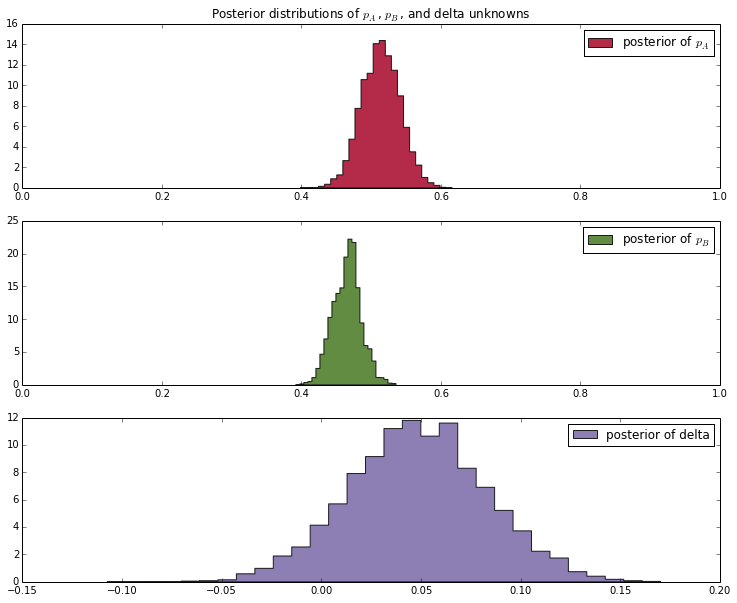

In [79]:
figsize(12.5, 10)

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, 1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, 1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
# plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
# plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
#            label="true delta (unknown)")
# plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [62]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print "Probability site A is WORSE than site B: %.3f" % \
    (delta_samples < 0).mean()

print "Probability site A is BETTER than site B: %.3f" % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.078
Probability site A is BETTER than site B: 0.922


In [63]:
# Or for frequentist statistics, written out long hand for clarity of what we're doing
muV1 = variant1_observations.mean()
muV2 = variant2_observations.mean()
muC = control_observations.mean()
SEV1 = muV1 * (1-muV1) / math.sqrt(len(variant1_observations))
SEV2 = muV2 * (1-muV2) / math.sqrt(len(variant2_observations))
SEC = muC * (1-muC) / math.sqrt(len(control_observations))
z1 = (muV1 - muC) / (SEV1**2 + SEC**2)**0.5
z2 = (muV2 - muC) / (SEV2**2 + SEC**2)**0.5

p1 = scipy.stats.norm.sf(abs(z1))*2 #twosided
p2 = scipy.stats.norm.sf(abs(z2))*2 #twosided

8.14773430614e-09


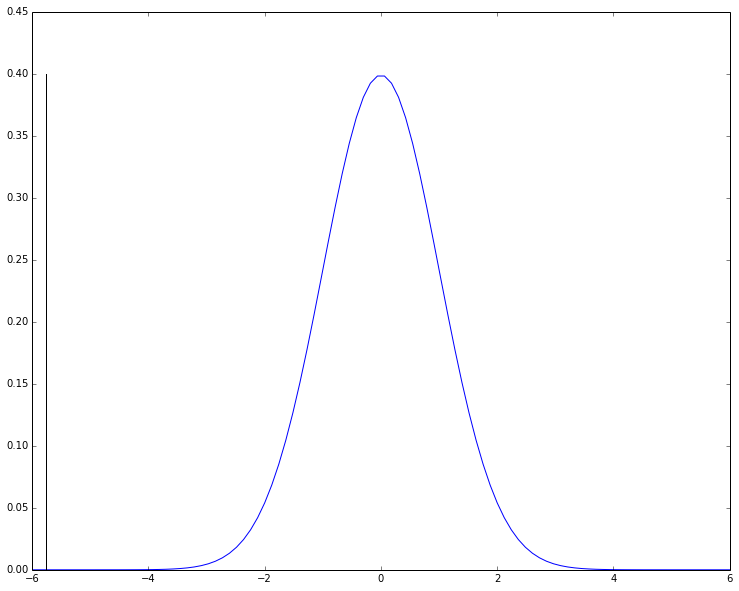

In [64]:
# plot the normal distribution
gaus = {
    'mean': 0,
    'variance': 1,
    'width': 4
}
if abs(z1) > 3:
    gaus['width'] = 6
else:
    gaus['width'] = 4

    
# plotting the chart
x = np.linspace(-gaus['width'],gaus['width'],100)
plt.plot(x, mlab.normpdf(x,gaus['mean'], gaus['variance']**0.5)) # plots a standard guasian plot
plt.plot((z1, z1), (0, 0.4), 'k-') # plots a vertical line where our z score comes, 0.4 is the height of the chart
plt.fill_between(x=x, 
                 y1=mlab.normpdf(x,gaus['mean'], gaus['variance']**0.5), 
                 interpolate=True,
                 where=abs(x)>abs(z1),
                 alpha=0.5)
print p1
plt.show()

0.00440584343202


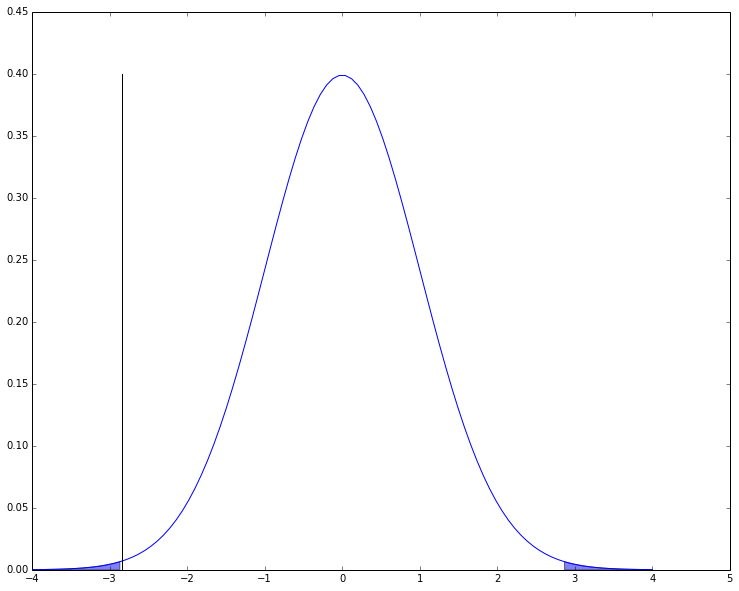

In [66]:
# plot the normal distribution
gaus = {
    'mean': 0,
    'variance': 1,
    'width': 4
}
if abs(z2) > 3:
    gaus['width'] = 6
else:
    gaus['width'] = 4

    
# plotting the chart
x = np.linspace(-gaus['width'],gaus['width'],100)
plt.plot(x, mlab.normpdf(x,gaus['mean'], gaus['variance']**0.5)) # plots a standard guasian plot
plt.plot((z2, z2), (0, 0.4), 'k-') # plots a vertical line where our z score comes, 0.4 is the height of the chart
plt.fill_between(x=x, 
                 y1=mlab.normpdf(x,gaus['mean'], gaus['variance']**0.5), 
                 interpolate=True,
                 where=abs(x)>abs(z2),
                 alpha=0.5)

print p2
plt.show()

In [72]:
delta1alt, p1alt = weightstats.ztest(control_observations, variant1_observations)
print delta1alt, p1alt

2.87783100183 0.004004195873
